In [1]:
# change the cwd
import os
os.chdir(os.getcwd()+"/HLP_Project/")

In [2]:
# import general use libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx

# silence matplotlib warnings
import warnings
warnings.filterwarnings('ignore')

# import developed libraries
from libs.cython.pyx.edgelistParser import edgelistParser
from libs.python.plotNetwork import plotNetworkClusters
from libs.cython.pyx.utils import (
    list2matrix,
    transposeEdgelist
)
from libs.cython.cpp.pageRankCpp import (
    cppGetDegree,
    cppLocalPageRank_weight as localPageRank_weight,
    cppApproximateSimrank as approximateSimrank,
    cppLocalPageRank as localPageRank
)
from libs.python.clustering import (
    build_network,
    cluster1,
    cluster3
)

In [50]:
names = ["Aggregation", "R15", "D31"]
A, positions = build_network("../datasets/" + names[2] + ".txt", radius=3.5)
N = len(positions)
A_mat = list2matrix(A, False)

# generate the L matrix
L = localPageRank(A, c=0.85, epsilon=1e-8, max_iters=200, return_only_neighbours=True)

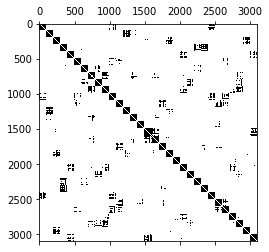

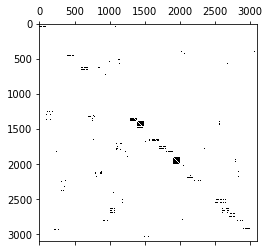

In [51]:
plt.figure()
plt.spy(A_mat)
plt.show()

L_T = transposeEdgelist(L, True)
L_mat_T = list2matrix(L_T)
plt.figure()
plt.spy(L_mat_T)
plt.show()

In [52]:
def getNeighsAvgDegree(node_list, degree):
    out = 0.
    for node in node_list:
        out += degree[node]
    if len(node_list) > 0:
        return out/len(node_list)
    else:
        return 0

In [58]:
def cluster_std(nodes, measure):
    clust_measure = measure[nodes]
    if clust_measure.shape[0] <= 1:
        return 0.
    return 1/(clust_measure.std())

In [59]:
# get in/out degrees
inDeg = np.sum(L_mat_T, axis=1)
outDeg = np.sum(L_mat_T, axis=0)

# get the ratio between the two
ratio = inDeg/outDeg
ratio[inDeg<=1e-15] = 0
ratio[outDeg<=1e-15] = 0

# and the average degree of the neighbours
avgNeighsInDeg = [0.]*N
avgNeighsOutDeg = [0.]*N

for i, node_list in enumerate(A):
    avgNeighsInDeg[i] = getNeighsAvgDegree(node_list, inDeg)
    avgNeighsOutDeg[i] = getNeighsAvgDegree(node_list, outDeg)
    
# compute ratio between in deg and average neighs in deg
ratio1 = np.array(inDeg)
ratio1[np.array(avgNeighsInDeg)==0] = 0
ratio1[np.array(avgNeighsInDeg)!=0] /= np.array(avgNeighsInDeg)[np.array(avgNeighsInDeg)!=0]
# do the same for the average neighs out deg
ratio2 = np.array(inDeg)
ratio2[np.array(avgNeighsOutDeg)==0] = 0
ratio2[np.array(avgNeighsOutDeg)!=0] /= np.array(avgNeighsOutDeg)[np.array(avgNeighsOutDeg)!=0]

ratio3 = np.array(avgNeighsInDeg)
ratio3[np.array(avgNeighsOutDeg)==0] = 0
ratio3[np.array(avgNeighsOutDeg)!=0] /= np.array(avgNeighsOutDeg)[np.array(avgNeighsOutDeg)!=0]

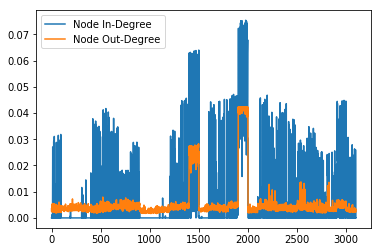

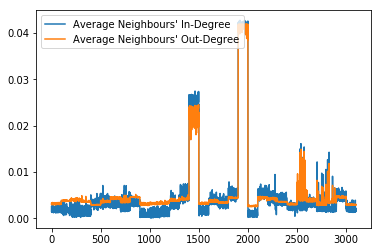

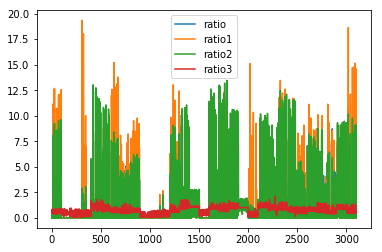

In [60]:
# plot the results
fig, ax = plt.subplots(1, 1)
ax.plot(inDeg)
ax.plot(outDeg)
ax.legend(["Node In-Degree", "Node Out-Degree"])
fig, ax = plt.subplots(1, 1)
ax.plot(avgNeighsInDeg)
ax.plot(avgNeighsOutDeg) # <- does not work well even in the simpler case
ax.legend(["Average Neighbours' In-Degree", "Average Neighbours' Out-Degree"])
fig, ax = plt.subplots(1, 1)
ax.plot(ratio)
ax.plot(ratio1)
ax.plot(ratio2)
ax.plot(ratio3)
ax.legend(["ratio", "ratio1", "ratio2", "ratio3"])

We start by assigning to each node a different cluster, we then merge the clusters of neighbouring nodes if the relevance measure of the cluster is higher after the merge.

In [61]:
# A and L are expected in edgelist form, measure is a numpy array
def cluster(A, L, measure, order):
    # node id 0->N-1
    clusters = np.arange(len(A), dtype=int)
    idxs = np.arange(len(A), dtype=int)
    link_to_follow = [[True for _ in node_list] for node_list in A]
    
    # initialize exit flag
    flag=True
    # while the exit flag is not False do
    while flag:
        flag = False
        old_clusts = np.array(clusters)
        # for each node
        for n, c in enumerate(clusters[order]):
            # extract the current cluster
            n = order[n]
            curr_cluster = idxs[clusters==c]
            # follow the link that corresponds to it's maximum relevance
            weights = np.array([e[1] for e in L[n]])[link_to_follow[n]]
            if weights.shape[0] > 0:
                max_idx = np.argmax(weights)
                link_to_follow[n][max_idx] = False
                neigh = L[n][max_idx][0]
                # make sure that the nodes are in different clusters
                if c != clusters[neigh]:
                    neigh_cluster = idxs[clusters==clusters[neigh]]
                    merge = cluster_std(list(curr_cluster)+list(neigh_cluster), measure)
                    clust1 = cluster_std(list(curr_cluster), measure)
                    clust2 = cluster_std(list(neigh_cluster), measure)
                    if clust1==clust2==0:
                        split = 0
                    else:
                        split = 2*clust1*clust2/(clust1**2+clust2**2)
                    #print("node:", n, "merge:", merge, "split", split)
                    if merge > split:
                        clusters[neigh_cluster] = c

        
        flag = not np.all(clusters==old_clusts)
        
    return clusters

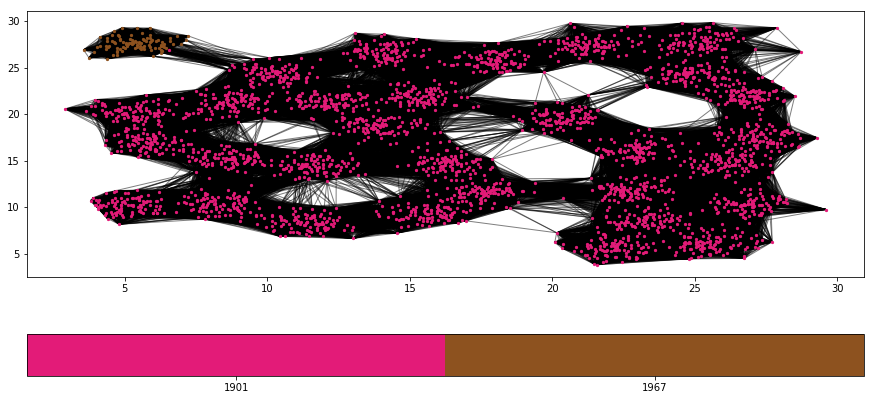

In [62]:
measure = np.array(avgNeighsInDeg)
order = np.argsort(measure)
clusters = cluster(A, L_T, measure, order)
pos, _ = plotNetworkClusters(A_mat, list(clusters.astype(int)), 5, draw_edges=True, pos=positions)